# The introductory computer exercise using Python and the SUND toolbox

This version of the exercise is implemented as a Python version using the SUND toolbox, running in an iPython notebook. The notebook can either be [run online in Google colab](https://colab.research.google.com/drive/1y37yYcxwSj5yd0yUePGxtvXZhJNkxf_-?usp=sharing), or <a href="https://isbgroup.eu/edu/courses/intro/computer_exercise/python_sund.ipynb" download>downloaded</a> and run locally.

Note: if running in Google colab, your downloaded and created files will be deleted after you close the session. If you decide to use it, make sure that you download backups! Furthermore, the first thing you should do is to save a copy of the notebook. To do this, press `File > Save a copy in Drive`.

## Introduction

### Purpose of the lab

This lab will on a conceptual level guide you through all the main sub-tasks in a systems biology project: model creation, model training using experimental data, model evaluation, and finally using the model to make predictions of new experiments.

This is an example of the steps the students should do in the exercise, but here implemented in Python. Step 0 revolves around setting up the environment, which will of course be very different when running in system modeller. In this example, I will lump together quite a lot of steps since they will most likely be completely different in the system modeller implementation

## Step 0: Setting up the environment

<details class="admonition success"><summary> Setting up the simulation toolbox</summary>

First make sure that you have a c-compiler installed. If you are running a unix-based operating system such as Mac OS or Linux you will have c-compiler already installed.

For Windows users you will need to install a c-compiler, for the newer Python distribution (version > 3.4) you will need to install the Microsoft Visual C++ compiler (MSVC). This can either be installed as a part of Visual Studios or as a standalone installation using Visual Studios Build Tools. [Here](https://wiki.python.org/moin/WindowsCompiler) can you see which compiler you need for your Python installations and follow the links to install the compiler.

Make sure you have pip (the Python package installer) installed: From the terminal (Unix-users) or command window (Windows-users) try running `pip --version` (Linux users may have to write `pip3`). If `pip` is not installed, follow instructions [here](https://packaging.python.org/tutorials/installing-packages/) to install it.

When you have ensured that pip is installed, check that setuptools are installed by running `pip show setuptools`. If installed it should show information about the setuptools package, such as version number. If not installed you can install it using pip: `pip install setuptools`.

After that you also need to install `numpy`, `matplotlib`, `jupyter` and the [`SUND toolbox`](https://isbgroup.eu/edu/assets/sund-1.0.3.1.tar.gz). The easiest way is to install the packages using `pip install ...` (e.g., `pip install numpy matplotlib jupyter https://isbgroup.eu/edu/assets/sund-1.0.4.tar.gz`).

</details>

Note, if running on Google Colab, you must use the cell below. Furthermore, the packages will only be installed on the remote connection, not on your local computer. You can also use this cell if running the notebook on your computer, but be aware that it will install packages in the current environment.

In [1]:
# Installing packages. Warning, this code cell will install packages to your computer.
%pip install numpy matplotlib jupyter
%pip install https://isbgroup.eu/edu/assets/sund-1.0.4.tar.gz


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached https://isbgroup.eu/edu/assets/sund-1.0.4.tar.gz (531 kB)
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import packages
import sys
import os
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import sund
import json
from scipy.stats import chi2
from scipy.optimize import Bounds
import csv
import random
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Setup numpy -> json encoder (might not be needed)
from json import JSONEncoder
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

Download the data

In [3]:
# Download the experimental data:
#!curl https://isbgroup.eu/edu/assets/Intro/Files/data_2024-03-12.json > data_2024-03-12.json

## Step 1: Implement a minimal model to get familiar with the software

Implement a first minimal model for NFKB activation
(This will most likely be given to the students, so that they have something to start with, to understand the basics of the software)

This is the model to implement:

![simple_model](assets/simple_model.svg)

In this version, these are the ODEs used: 

```c

########## STATES
d/dt(NFKBinactive) = -vact + vinact
d/dt(NFKBactive)   =  vact - vinact

NFKBinactive(0)=100
NFKBactive(0)=0

########## PARAMETERS
k1 = 1 //values does not mean anything, overwritten later
k2 = 1

########## VARIABLES
vact   = LPS * NFKBinactive * k1 
vinact = NFKBactive * k2 

```

Make a first simulation, play around with changing the parameter values and simulation length.

(change time in the code to change the simulated time)

In [4]:
# Install/load the model (note that the notebook must be restarted if the model file is updated)
sund.installModel('models/simple.txt')
Simple = sund.importModel('simple')
simple = Simple() # get the object from the model class

# Define functions to simulate and plot the simulation
def plot_feature(simulation, featurename):
    plt.plot(simulation['time'], simulation[featurename])
    plt.xlabel('Time')
    plt.ylabel('Response (a.u.)')
    plt.title(featurename)

def simulate_and_plot(model, time, params=[1,2], LPS=1, features_to_plot = None):
    if features_to_plot is None:
        features_to_plot = model.featurenames
    stimulation_activity = sund.Activity(timeunit='m')
    stimulation_activity.AddOutput(sund.PIECEWISE_CONSTANT, 'LPS', tvalues = [5], fvalues = [0, LPS])
    simulation = sund.Simulation(timeunit='m', models=model, activities=stimulation_activity)
    simulation.Simulate(timevector = time, resetstatesderivatives=True, parametervalues=params)
    feature_data = simulation.featuredata_dict()
    feature_data["time"] = simulation.timevector

    for feature in features_to_plot:
        plt.figure()
        plot_feature(feature_data, feature)
    plt.show()

# Simulate and plot
time = np.linspace(0, 30, 1000)
@interact(k1=(0.00001,0.5, 0.001), k2=(0.00001,0.5, 0.001))
def handle_input(k1=0.2, k2=0.1):
    simulate_and_plot(simple, time, [k1,k2])

Model 'simple' succesfully installed.


/home/william/projects/sysbio-intro-xhide/models/simple.c: In function ‘simple_initialcondition’:
/home/william/projects/sysbio-intro-xhide/models/simple.c:81:19: warning: variable ‘k2’ set but not used [-Wunused-but-set-variable]
   81 |         double k1,k2;
      |                   ^~
/home/william/projects/sysbio-intro-xhide/models/simple.c:81:16: warning: variable ‘k1’ set but not used [-Wunused-but-set-variable]
   81 |         double k1,k2;
      |                ^~


interactive(children=(FloatSlider(value=0.2, description='k1', max=0.5, min=1e-05, step=0.001), FloatSlider(va…

The first data that was measured, was TNF released from the cells. Complement the model to include also the creation/secretion of TNF. 

This is the model to implement:

![simple_model_with_TNF](assets/simple_model_with_TNF.svg)

In this version, these are the ODEs used: 

```c
########## STATES
d/dt(NFKBinactive) = -vact + vinact
d/dt(NFKBactive)   =  vact - vinact
d/dt(TNFEC)        =  vsynt - vdeg

NFKBinactive(0)=100
NFKBactive(0)=0
TNFEC(0)=0

########## PARAMETERS
k1 = 1 //values does not mean anything, overwritten later
k2 = 1
k3 = 1
k4 = 1

########## VARIABLES
vact=LPS*NFKBinactive*k1 
vinact=NFKBactive*k2 
vsynt = k2*NFKBactive
vdeg = k3*TNFEC
```

In [5]:
# Install/load the model (note that the notebook must be restarted if the model file is updated)
sund.installModel('models/simple_TNF.txt')
Simple_TNF = sund.importModel('simple_TNF')
simple_TNF = Simple_TNF() # get the object from the model class

# Simulate and plot
time = np.linspace(0, 30, 1000)
@interact(k1=(0.00001,0.5, 0.001), 
          k2=(0.00001,0.5, 0.001),
          k3=(0.00001,0.5, 0.001),
          k4=(0.00001,0.5, 0.001))
          
def handle_input(k1=0.2, k2=0.1, k3=0.2, k4=0.1):
    simulate_and_plot(simple_TNF, time, [k1,k2, k3, k4])

Model 'simple_TNF' succesfully installed.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.11/logging/__init__.py", line 1113, in emit
    stream.write(msg + self.terminator)
ValueError: I/O operation on closed file.
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/william/.local/share/virtualenvs/sysbio-intro-xhide-vIYHI2rM/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/william/.local/share/virtualenvs/sysbio-intro-xhide-vIYHI2rM/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/william/.local/share/virtualenvs/sysbio-intro-xhide-vIYHI2rM/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/william/.local/share/virtualenvs/sysbio-intro-xhide-vIYHI2rM/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 

interactive(children=(FloatSlider(value=0.2, description='k1', max=0.5, min=1e-05, step=0.001), FloatSlider(va…

Compare to some set of the data, how good can the agreement get? 

Fit the model to the data using system modeller parameter estimation

Change the kinetics, can the agreement get better? 

The need for a more complex model. 

Let the students implement a model that they themselves have put together. 
(should there be a hand in of the suggested map before they do this?)

Let the students implement the fully complex model (the published one).

Make predictions of a new experiment 
(perhaps dual stimulation, and compare to some "blue model" data?)

## Main computer lab tasks

*Have you read the introduction above?*

#### Import the necessary packages

### Getting familiar with the data

#### Download the experimental data

#### Load the experimental data from data.json

In [135]:
# load data, using the `with` statement
with open("data_2024-03-12.json", "rb") as f:
    data = json.load(f)

In [ ]:
# split the data into training and validation data
data_validation = data.pop('step_dose')

#### Implement and then call the `plot_data` function

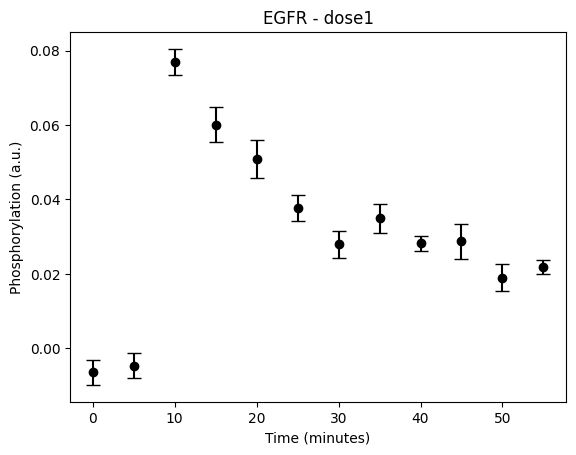

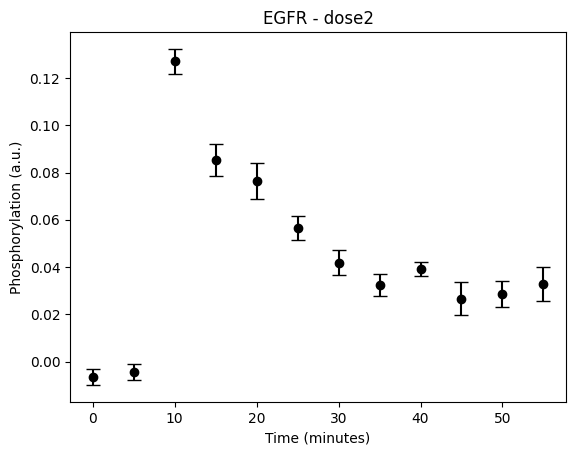

In [136]:
# Define a function to plot one dataset
def plot_dataset(data, FC='k'):
    plt.errorbar(data['time'], data['mean'], data['SEM'], linestyle='None', marker='o', markerfacecolor=FC, color='k', capsize=5)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Phosphorylation (a.u.)')
    plt.axis((0, 60, 0, 0.15))


# Define a function to plot all datasets
def plot_data(data):
  for idx, experiment in enumerate(data):
        plt.figure(idx)
        plot_dataset(data[experiment])
        plt.title(f'EGFR - {experiment}')

plot_data(data)

## Implementing and simulating a model

Lets create the model. Either create a new file to save the model in, or use the code cell below to save the model to file

In [137]:
# Print the model to a file called 'M1.txt'

model_name = "M1"

with open(f"{model_name}.txt",'w') as f:
    f.write(f"""
########## NAME
{model_name}
########## METADATA
timeunit = m
########## MACROS
########## STATES
d/dt(R) = r3+r2-r1
d/dt(Rp) = r1-r2-r3
d/dt(S) = r4-r5
d/dt(Sp) = r5-r4

R(0) = 1.0
Rp(0) = 0.0
S(0) = 1.0
Sp(0) = 0.0
########## PARAMETERS
k1 = 1.0
k2 = 0.0001
kfeed = 1000000.0
k4 = 1.0
k5 = 0.01
########## VARIABLES
r1 = R*A*k1
r2 = Rp*k2
r3 = Rp*Sp*kfeed
r4 = Sp*k4
r5 = S*Rp*k5
########## FUNCTIONS
########## EVENTS
########## OUTPUTS
########## INPUTS
A = A_in @ 1
########## FEATURES
y_sim = Rp
""")

#### Install the created model.

In [138]:
# Install the simple model by using the sund function 'installModel'
# To see that the model has been installed try running 'M1' afterwards
sund.installModel("M1.txt")

Model 'M1' has already been imported into memory. 
Trying to unload the module, but you might need to restart Python before re-installing the model.


INFO:root:running build_ext
INFO:root:building 'sund.Models.M1' extension
INFO:root:creating build
INFO:root:creating build/temp.linux-x86_64-cpython-310
INFO:root:creating build/temp.linux-x86_64-cpython-310/content
INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.10/dist-packages/sund/Models/include -I/usr/include/python3.10 -c /content/M1.c -o build/temp.linux-x86_64-cpython-310/content/M1.o
INFO:root:x86_64-linux-gnu-gcc -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 build/temp.linux-x86_64-cpython-310/content/M1.o -L/usr/local/lib/python3.10/dist-packages/sund/Models/include -L/usr/lib/x86_64-linux-gnu -lExtraFormulas -o /usr/local/lib/python3.10/dist-packages/sund/Models/M1.cpython-310-x86_64-linux-gnu.so
INFO:root:running clean
INFO:root:removing 'build/temp.linux-x86_64-cpython-310' (and everyt

Model 'M1' succesfully installed.


#### Import the model class

In [139]:
# Import the simple model by using the sund function 'importModel'
# The function return the model class which should be stored in variable, say 'M1'
M1 = sund.importModel("M1")

#### Create a model object from the model class

In [140]:
# Create a new simple model object by calling the class constructor 'SimpleModel()'
# Store the resulting object in a variable, say 'm1'

m1 = M1()
m1.statevalues = [2, 2, 2, 2]
print(m1.statevalues)
m1.ResetStatesDerivatives()
print(m1.statevalues)

[2. 2. 2. 2.]
[1. 0. 1. 0.]


#### Create an activity object

In [141]:
# Create two activity object, which sets A_in to the input values stored in the data file. 

activity1 = sund.Activity(timeunit='m')
activity1.AddOutput(sund.PIECEWISE_CONSTANT, "A_in", tvalues = data['dose1']['input']['A_in']['t'], fvalues=data['dose1']['input']['A_in']['f'])

activity2 = sund.Activity(timeunit='m')
activity2.AddOutput(sund.PIECEWISE_CONSTANT, "A_in", tvalues = data['dose2']['input']['A_in']['t'], fvalues=data['dose2']['input']['A_in']['f'])

#### Create a simulation object and simulate

In [142]:
# Create a new Simulation object for the m1 object using the constructor `sund.Simulation(models=models)` from the sund package.
m1_sims = {}
m1_sims['dose1'] = sund.Simulation(models = m1, activities = activity1, timeunit = 'm')
m1_sims['dose2'] = sund.Simulation(models = m1, activities = activity2, timeunit = 'm')

# Simulate the m1_simulation object, remember to specify the timevector ([times to simulate]) and timeunit ('s' | 'm' | 'h' ).
timepoints = np.arange(0, data['dose1']['input']['A_in']['t'][-1]+0.01, 0.01) # 6000 points between 0 and 60.
m1_sims['dose1'].Simulate(timevector=timepoints)
m1_sims['dose2'].Simulate(timevector=timepoints)

#### Observe the simulation result

In [143]:
# Print and/or plot the result of the simulation above
print(f"Values after first simulation: {m1_sims['dose1'].featuredata[:,0]}")
print(f"featurenames: {m1_sims['dose1'].featurenames}")

# Also try to simulate twice, before plotting, does it change the plot?
m1_sims['dose1'].Simulate(timevector=timepoints)
print(f"Values after simulating twice: {m1_sims['dose1'].featuredata[:,0]}")

Values after first simulation: [0.         0.         0.         ... 0.00995062 0.00995062 0.00995062]
featurenames: ['y_sim']
Values after simulating twice: [0.00995062 0.00368289 0.00137134 ... 0.00995061 0.00995061 0.00995061]


Observe states and derivatives

In [144]:
# Observe the states values of both the simulations object 'm1_simulation'
# and the model object 'm1'. Note that they differ.
print(f"Simulation state values before reset: {m1_sims['dose1'].statevalues}")
print(f"Model state values before reset: {m1_sims['dose1'].statevalues}")

# Reset the states of the simulation object, and check the state values again.
m1_sims['dose1'].ResetStatesDerivatives()
print(f"Simulation state values after reset: {m1_sims['dose1'].statevalues}")
print(f"Model state values after reset: {m1_sims['dose1'].statevalues}")

Simulation state values before reset: [9.90049388e-01 9.95061221e-03 9.99900504e-01 9.94962212e-05]
Model state values before reset: [9.90049388e-01 9.95061221e-03 9.99900504e-01 9.94962212e-05]
Simulation state values after reset: [1. 0. 1. 0.]
Model state values after reset: [1. 0. 1. 0.]


#### Running the same simulation with different parameter values

In [145]:
# Run two simulations with different parameter values, but the same initial conditions.
m1_sims['dose1'].Simulate(parametervalues=[1, 0.0001, 1000000, 1, 0.001], resetstatesderivatives=True)
print(f"Simulation state values with first parameter set: {m1_sims['dose1'].statevalues}")

# `simple_model_simulation.Simulate(parametervalues=[2.0], resetstatesderivatives=True)`
m1_sims['dose1'].Simulate(parametervalues=[1, 1, 100, 1, 1], resetstatesderivatives=True)
print(f"Simulation state values with first parameter set: {m1_sims['dose1'].statevalues}")

Simulation state values with first parameter set: [9.68872855e-01 3.11271446e-02 9.99968874e-01 3.11261529e-05]
Simulation state values with first parameter set: [0.90576594 0.09423406 0.91388126 0.08611874]


#### Simulate the hypothesis using the provided parameter values, plot and compare to data

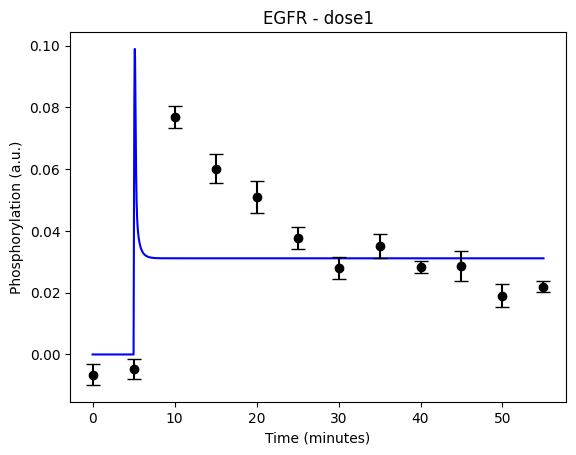

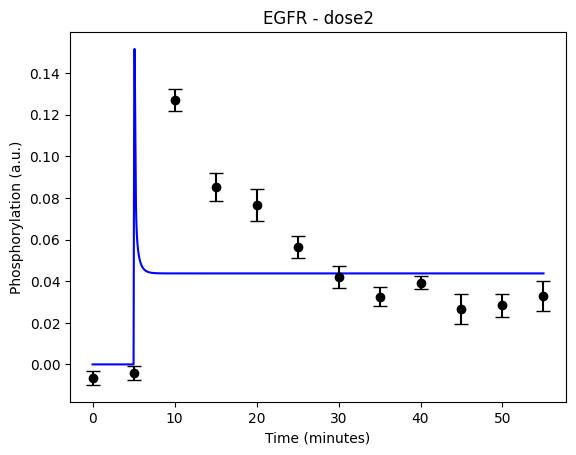

In [146]:
# Define a function to plot the simulation
def plot_sim(params, sim, timepoints, c='b', feature_to_plot='y_sim'):
    # Setup, simulate, and plot the model
    sim.Simulate(timevector = timepoints,
                    parametervalues = params,
                    resetstatesderivatives = True)

    feature_idx = sim.featurenames.index(feature_to_plot)
    plt.plot(sim.timevector, sim.featuredata[:,feature_idx], c)


# Define a function to plot the simulations together with the data
def plot_sim_with_data(params, sims, data, c='b'):

    for idx, experiment in enumerate(data):
        plt.figure()
        timepoints = np.arange(0, data[experiment]["time"][-1]+0.01, 0.01)
        plot_sim(params, sims[experiment], timepoints, c)
        plot_dataset(data[experiment])
        plt.title(f'EGFR - {experiment}')


# Plot the model with the given parameter values:
params0_M1 = [1, 0.0001, 1000000, 1, 0.001] # = [k1, k2, kfeed, k4, k5]
plot_sim_with_data(params0_M1, m1_sims, data)

#### Improve the agreement to data

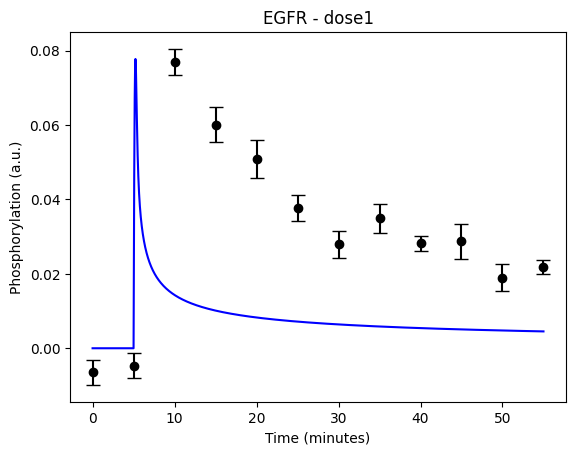

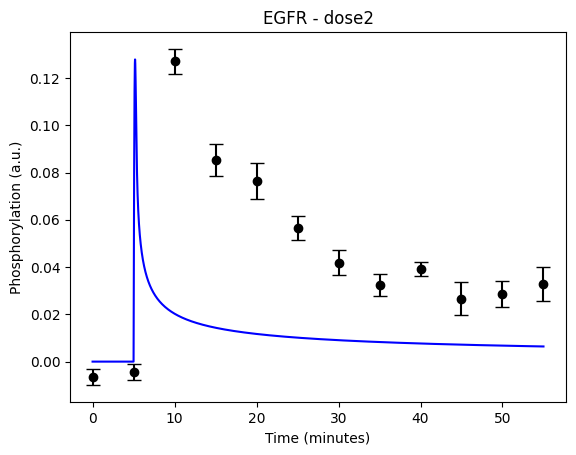

In [147]:
# manually test new parameter values 
params0_M1 = [0.7124706004063569, 4.252441906377741, 999999.2928571177, 1e-06, 0.00034656169728757594]

#plot the model agreement to data
plot_sim_with_data(params0_M1, m1_sims, data)

## Evaluating and improving the agreement to data

#### Implement a cost function:

In [148]:
# Define the cost function
def fcost(params, sims, data):
    cost=0
    for experiment in data.keys():
        try:
            sims[experiment].Simulate(timevector = data[experiment]["time"],
                                parametervalues = params,
                                resetstatesderivatives = True)

            y_sim = sims[experiment].featuredata[:,0]
            y = data[experiment]["mean"]
            SEM = data[experiment]["SEM"]

            cost += np.sum(np.square(((y_sim - y) / SEM)))

        except Exception as e:
            # print(str(e)) # print exception, not generally useful
            cost+=1e30  # in-case of exception add a "high cost"


    return cost

#### Calculate the cost for the initial parameter set

In [149]:
# Calculate the cost for the initial parameter set for M1
param0_M1 = [1, 0.0001, 1000000, 1, 0.01] # = [k1, k2, kfeed, k4, k5]
cost_M1 =  fcost(param0_M1, m1_sims, data)
print(f"Cost of the M1 model: {cost_M1}")

Cost of the M1 model: 1661.9900767258441


#### Test a parameter set which gives a simulation that crashes

In [150]:
# Test a known incorrect parameter set which should make the simulation crash
param_fail = [-1e16, -1e16, -1e16, -1e16, -1e16]
cost_M1 =  fcost(param_fail, m1_sims, data)
print(f"Cost of the M1 model: {cost_M1}")

Cost of the M1 model: 2e+30


## Evaluating if the agreement is good enough

#### Compare the cost to a $\chi^2$-test

In [151]:
# Evaluate the model with the intial parameter values by comparing the cost to the chi2-limit
cost = fcost(param0_M1, m1_sims, data)
dgf=0
for experiment in data:
  dgf += np.count_nonzero(np.isfinite(data[experiment]["SEM"]))
chi2_limit = chi2.ppf(0.95, dgf) # Here, 0.95 corresponds to 0.05 significance level
print(f"Chi2 limit: {chi2_limit}")
print(f"Cost > limit (rejected?): {cost_M1>chi2_limit}")

Chi2 limit: 36.41502850180731
Cost > limit (rejected?): True


### Improving the agreement

#### Improve the agreement (manually)

Cost of the M1 model: 33.475462065476364
Chi2 limit: 36.41502850180731
Cost > limit (rejected?): False


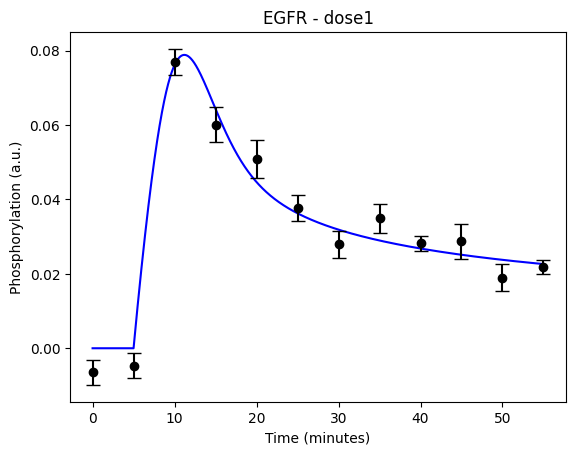

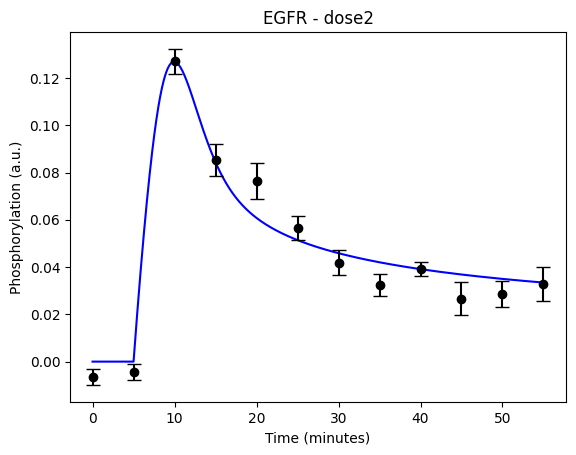

In [152]:
# Manually evaluate the agreement by testing parameter values
param_guess_M1 = [0.0236688391156194, 0.0934663465415150, 3.30012621757067, 1.00000000000000e-05, 0.176301407375774] # Change the values here and try to find a better agreement, if you tried to find a better agreement visually above, you can copy the values here
cost =  fcost(param_guess_M1, m1_sims, data)
print(f"Cost of the M1 model: {cost}")

# Find the degrees of freedom
dgf=0
for experiment in data:
  dgf += np.count_nonzero(np.isfinite(data[experiment]["SEM"]))
  
# Find the chi-2 limit
chi2_limit = chi2.ppf(0.95, dgf)
print(f"Chi2 limit: {chi2_limit}")
print(f"Cost > limit (rejected?): {cost>chi2_limit}")

# Plot the model agreement to data
plot_sim_with_data(param_guess_M1, m1_sims, data)

### Improve the agreement using optimization methods

In [281]:
# Setup inputs and functions needed for the optimization

x0_log_M1 = np.log(param0_M1)

args_M1 = (m1_sims, data)

bounds_M1 = Bounds([np.log(1e-6)]*len(x0_log_M1), [np.log(1e6)]*len(x0_log_M1)) # Create a bounds object needed for some of the solvers

def fcost_log(params, sims, data):
    return fcost(np.exp(params), sims, data)

def callback(x, file_name):
    with open(f"./{file_name}.json",'w') as file:
        out = {"x": np.exp(x)}
        json.dump(out,file, cls=NumpyArrayEncoder)

In [282]:
# Optimize using differential_evolution
def callback_evolution_M1(x, convergence): # The callback to the differential_evolution optimizer returns both the current point x, and state of convergence
    callback(x, file_name='M1-temp-evolution')

from scipy.optimize import differential_evolution
result_evolution = differential_evolution(fcost_log, bounds_M1, args=args_M1, callback=callback_evolution_M1, disp=True) # seems to perform the best
result_evolution['x'] = np.exp(result_evolution['x']) # convert back to linear scale
print(result_evolution)

print(f"\nOptimized parameter values: {result_evolution['x']}")
print(f"Optimized cost: {result_evolution['fun']}")
print(f"chi2-limit: {chi2_limit}")
print(f"Cost > limit (rejected?): {result_evolution['fun']>chi2_limit}")

if result_evolution['fun'] < chi2_limit: #Saves the parameter values, if the cost was below the limit.
    file_name = f"M1 ({result_evolution['fun']:.3f}) - differential_evolution.json"
    with open(file_name,'w') as file:
        result_evolution['x'] = result_evolution['x'] #We save the file as a .json file
        json.dump(result_evolution, file, cls=NumpyArrayEncoder)

differential_evolution step 1: f(x)= 615.77
differential_evolution step 2: f(x)= 594.006
differential_evolution step 3: f(x)= 119.862
differential_evolution step 4: f(x)= 119.862
differential_evolution step 5: f(x)= 119.862
differential_evolution step 6: f(x)= 119.862
differential_evolution step 7: f(x)= 119.862
differential_evolution step 8: f(x)= 119.862
differential_evolution step 9: f(x)= 119.862
differential_evolution step 10: f(x)= 107.197
differential_evolution step 11: f(x)= 107.197
differential_evolution step 12: f(x)= 57.1284
differential_evolution step 13: f(x)= 57.1284
differential_evolution step 14: f(x)= 57.1284
differential_evolution step 15: f(x)= 57.1284
differential_evolution step 16: f(x)= 57.1284
differential_evolution step 17: f(x)= 53.5106
differential_evolution step 18: f(x)= 50.1933
differential_evolution step 19: f(x)= 50.1933
differential_evolution step 20: f(x)= 50.1933
differential_evolution step 21: f(x)= 50.1933
differential_evolution step 22: f(x)= 50.193

In [283]:
# Optimize using dual annealing
def callback_dual(x,f,c):
    global niter
    file_name = 'M1-temp-dual.json'

    if niter%1 == 0:
        print(f"Iter: {niter:4d}, obj:{f:3.6f}", file=sys.stdout)
        with open(f"./{file_name}",'w') as file:
            out = {"f": f, "x": np.exp(x)}
            json.dump(out,file, cls=NumpyArrayEncoder)
    niter+=1

from scipy.optimize import dual_annealing
niter=0
print(x0_log_M1)
result_dual = dual_annealing(fcost_log, bounds_M1, x0=x0_log_M1, args=args_M1, callback=callback_dual)
result_dual['x'] = np.exp(result_dual['x']) # convert back to linear scale
print(result_dual)

print(f"\nOptimized parameter values: {result_dual['x']}")
print(f"Optimized cost: {result_dual['fun']}")
print(f"chi2-limit: {chi2_limit}")
print(f"Cost > limit (rejected?): {result_dual['fun']>chi2_limit}")

if result_dual['fun'] < chi2_limit: #Saves the parameter values, if the cost was below the limit.
    file_name = f"M1 ({result_dual['fun']:.3f}) - dual_annealing.json"
    with open(file_name,'w') as file:
        json.dump(result_dual, file, cls=NumpyArrayEncoder)

[ 0.         -9.21034037 13.81551056  0.         -4.60517019]
Iter:    0, obj:1546.766445
Iter:    1, obj:754.974776
Iter:    2, obj:645.954939
Iter:    3, obj:630.498455
Iter:    4, obj:588.586412
Iter:    5, obj:142.508795
Iter:    6, obj:142.506649
Iter:    7, obj:130.361494
Iter:    8, obj:130.350607
Iter:    9, obj:110.496401
Iter:   10, obj:110.490029
Iter:   11, obj:110.412049
Iter:   12, obj:86.087999
Iter:   13, obj:77.416142
Iter:   14, obj:75.818310
Iter:   15, obj:72.814112
Iter:   16, obj:55.326269
Iter:   17, obj:55.322932
Iter:   18, obj:55.321182
Iter:   19, obj:54.814974
Iter:   20, obj:54.814935
Iter:   21, obj:54.809769
Iter:   22, obj:53.634995
Iter:   23, obj:53.625466
Iter:   24, obj:52.165498
Iter:   25, obj:52.164147
Iter:   26, obj:52.085506
Iter:   27, obj:52.076515
Iter:   28, obj:52.075162
Iter:   29, obj:52.072314
Iter:   30, obj:52.071731
Iter:   31, obj:52.070559
Iter:   32, obj:52.070073
Iter:   33, obj:52.069559
Iter:   34, obj:52.069494
Iter:   35, obj

In [284]:
# Optimize using SHG optimization
from scipy.optimize import shgo

def callback_shgo_M1(x):
    callback(x, file_name='M1-temp-SHGO')

result_shgo = shgo(fcost_log, bounds_M1, args=args_M1, callback=callback_shgo_M1, options = {"disp":True})
result_shgo['x'] = np.exp(result_shgo['x']) # convert back to linear scale
print(result_shgo)

print(f"\nOptimized parameter values: {result_shgo['x']}")
print(f"Optimized cost: {result_shgo['fun']}")
print(f"chi2-limit: {chi2_limit}")
print(f"Cost > limit (rejected?): {result_shgo['fun']>chi2_limit}")

if result_shgo['fun'] < chi2_limit: #Saves the parameter values, if the cost was below the limit.
    file_name = f"M1 ({result_shgo['fun']:.3f}) - SHGO.json"
    with open(file_name,'w') as file:
        json.dump(result_shgo, file, cls=NumpyArrayEncoder)

INFO:root:Splitting first generation
INFO:root:Constructing and refining simplicial complex graph structure
INFO:root:Triangulation completed, evaluating all contraints and objective function values.
INFO:root:Evaluations completed.
INFO:root:Searching for minimizer pool...
INFO:root:============================================================
INFO:root:v.x = [-13.81551056 -13.81551056 -13.81551056  13.81551056  13.81551056] is minimizer
INFO:root:v.f = 2712.39448291246 is minimizer
INFO:root:==============================
INFO:root:Neighbors:
INFO:root:==============================
INFO:root:x = (-13.815510557964274, -13.815510557964274, -13.815510557964274, -13.815510557964274, -13.815510557964274) || f = 2712.423261077646
INFO:root:x = (13.815510557964274, -13.815510557964274, 13.815510557964274, 13.815510557964274, 13.815510557964274) || f = 703496.4659762549
INFO:root:x = (13.815510557964274, 13.815510557964274, 13.815510557964274, 13.815510557964274, 13.815510557964274) || f = 2

 message: Optimization terminated successfully.
 success: True
     fun: 1559.574270578385
    funl: [ 1.560e+03]
       x: [ 6.280e-04  1.752e-05  1.198e-06  1.023e+00  7.802e+05]
      xl: [[-7.373e+00 -1.095e+01 -1.363e+01  2.316e-02  1.357e+01]]
     nit: 1
    nfev: 228
   nlfev: 195
   nljev: 20
   nlhev: 0

Optimized parameter values: [6.27954119e-04 1.75211451e-05 1.19795414e-06 1.02342801e+00
 7.80194424e+05]
Optimized cost: 1559.574270578385
chi2-limit: 36.41502850180731
Cost > limit (rejected?): True


In [285]:
# Optimize using DIRECT
from scipy.optimize import direct

def callback_direct(x):
    callback(x, file_name='M1-temp-DIRECT')

result_direct = direct(fcost_log, bounds_M1, args=args_M1, callback=callback_direct)
result_direct['x'] = np.exp(result_direct['x']) # convert back to linear scale
print(result_direct)

print(f"\nOptimized parameter values: {result_direct['x']}")
print(f"Optimized cost: {result_direct['fun']}")
print(f"chi2-limit: {chi2_limit}")
print(f"Cost > limit (rejected?): {result_direct['fun']>chi2_limit}")

if result_direct['fun'] < chi2_limit: #Saves the parameter values, if the cost was below the limit.
    file_name = f"M1 ({result_direct['fun']:.3f}) - DIRECT.json"
    with open(file_name,'w') as file:
        json.dump(result_direct, file, cls=NumpyArrayEncoder)

 message: The volume of the hyperrectangle containing the lowest function value found is below vol_tol=1e-16
 success: True
  status: 4
     fun: 101.2041122409882
       x: [ 9.874e-01  9.096e-03  4.642e+02  1.006e-02  4.583e-02]
     nit: 41
    nfev: 727

Optimized parameter values: [9.87445265e-01 9.09594314e-03 4.64158883e+02 1.00633710e-02
 4.58331492e-02]
Optimized cost: 101.2041122409882
chi2-limit: 36.41502850180731
Cost > limit (rejected?): True


In [286]:
# Optimize using local solvers
from scipy.optimize import minimize

method = 'TNC' # 'COBYLA', 'TNC', 'L-BFGS'

def callback_local(x):
    callback(x, file_name=f'M1-temp-{method}')

result_local = minimize(fcost_log, x0=x0_log_M1, method=method, bounds=bounds_M1, args=args_M1, callback=callback_local)
result_local['x'] = np.exp(result_local['x']) # convert back to linear scale
print(result_local)

print(f"\nOptimized parameter values: {result_local['x']}")
print(f"Optimized cost: {result_local['fun']}")
print(f"chi2-limit: {chi2_limit}")
print(f"Cost > limit (rejected?): {result_local['fun']>chi2_limit}")

if result_local['fun'] < chi2_limit: #Saves the parameter values, if the cost was below the limit.
    file_name = f"M1 ({result_local['fun']:.3f}) - {method}.json"
    with open(file_name,'w') as file:
        json.dump(result_local, file, cls=NumpyArrayEncoder)

 message: Linear search failed
 success: False
  status: 4
     fun: 1661.9876051317822
       x: [ 1.000e+00  1.000e-04  1.000e+06  1.000e+00  1.000e-02]
     nit: 1
     jac: [-3.472e+05  3.480e+05 -1.748e+06  7.882e+04 -2.202e+05]
    nfev: 42

Optimized parameter values: [1.e+00 1.e-04 1.e+06 1.e+00 1.e-02]
Optimized cost: 1661.9876051317822
chi2-limit: 36.41502850180731
Cost > limit (rejected?): True


#### Load the best found parameter set so far

In [287]:
# Load the best found parameter set
directory = './'
model_name = 'M1'
min_file = min((f for f in os.listdir(directory) if f.startswith(model_name) and f.endswith('.json')) , key=lambda f: float(re.search(r'\((\d+\.\d+)\)', f).group(1)) if re.search(r'\((\d+\.\d+)\)', f) else float('inf'))
print(f"Best parameters file: {min_file}")
with open(min_file,'r') as f:
    res_opt = json.load(f)
p_opt_M1 = res_opt['x']
print(p_opt_M1)

Best parameters file: M1 (30.518) - differential_evolution.json
[0.02610716056966139, 0.14089290459422346, 34603.26328706883, 8.576658770311998e-06, 1.5209384916371462e-05]


Plot the best found parameter sets

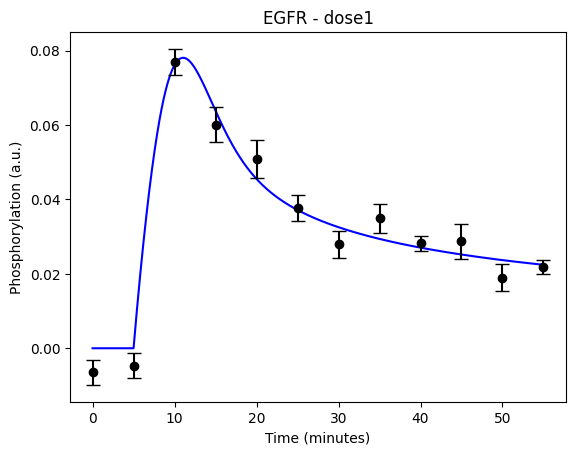

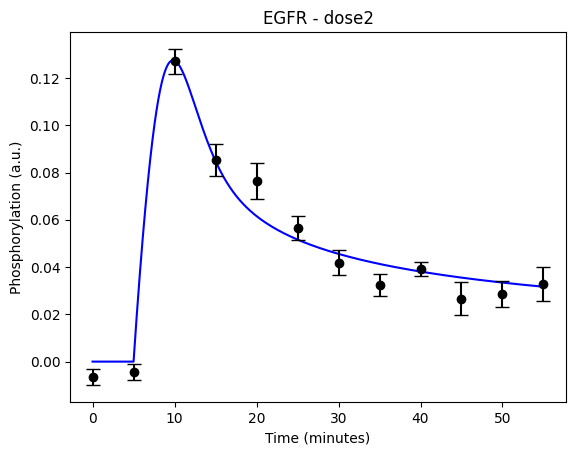

In [288]:
# Use the best found parameter sets to plot the agreement to data
plot_sim_with_data(p_opt_M1, m1_sims, data)

### Estimating the model uncertainty

In [ ]:
# Create an empty list to store multiple parameter sets
all_params_M1 = []

#### Update the cost function to store multiple parameter sets

In [289]:
# Update the cost function to store acceptable parameters
def fcost_uncertainty(params, sims, data, params_list):

    cost = fcost_log(params, sims, data)

    dgf = 0
    for experiment in data:
        dgf += np.count_nonzero(np.isfinite(data[experiment]["SEM"]))

    chi2_limit = chi2.ppf(0.95, dgf) # Here, 0.95 corresponds to 0.05 significance level

    if cost < chi2_limit:
        params_list.append(np.exp(params))

    return cost

In [291]:
# Run the optimization a couple times and store the satisfactory parameters in the above created list.
x0_log_M1 = np.log(x0_log_M1) # [0.0236688391156194, 0.0934663465415150, 3.30012621757067, 1.00000000000000e-05, 0.176301407375774]
args_M1 = (m1_sims, data, all_params_M1)

for i in range(4):
    res_uncM1 = differential_evolution(fcost_uncertainty, bounds_M1, args=args_M1, x0=x0_log_M1, callback=callback_evolution_M1, disp=True)
    x0_log_M1 = res_uncM1['x']

Iter:   41, obj:981.863110
Iter:   42, obj:614.527060
Iter:   43, obj:614.527057
Iter:   44, obj:603.437535
Iter:   45, obj:557.990680
Iter:   46, obj:58.024522
Iter:   47, obj:56.119769
Iter:   48, obj:31.169970
Iter:   49, obj:31.169969
Iter:   50, obj:31.169969
Iter:   51, obj:31.169943
Iter:   52, obj:31.168738
Iter:   53, obj:31.168737
Iter:   54, obj:31.168692
Iter:   55, obj:31.168344
Iter:   56, obj:31.168297
Iter:   57, obj:31.168296
Iter:   58, obj:31.168296
Iter:   59, obj:31.168246
Iter:   60, obj:31.167546
Iter:   61, obj:31.167519
Iter:   62, obj:31.167519
Iter:   63, obj:31.167519
Iter:   64, obj:31.167518
Iter:   65, obj:31.167517
Iter:   66, obj:31.167516


#### Save the collected values to file

In [292]:
# Save the accepted parameters to a csv file
with open('all_params_M1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows(all_params_M1)

### Plot the uncertainty by simulating and plotting your collected parameter sets

#### Define function to plot the simulation of one parameter set

In [293]:
# Define a function to plot the model uncertainty
def plot_uncertainty(all_params, sims, data, c='b', n_params_to_plot=200):
    random.shuffle(all_params)

    for idx, experiment in enumerate(data):
        # Plot the simulations
        plt.figure(idx) # Create a new figure
        timepoints = np.arange(0, data[experiment]["time"][-1]+0.01, 0.01)

        for param in all_params[:n_params_to_plot]:
            plot_sim(param, sims[experiment], timepoints, c)

        # Plot the data
        plot_dataset(data[experiment])

        plt.title(f'EGFR - {experiment}')

#### Plot the uncertainty using the collected parameter sets

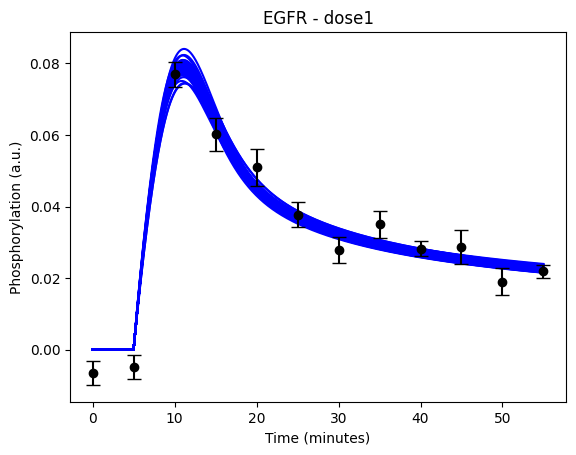

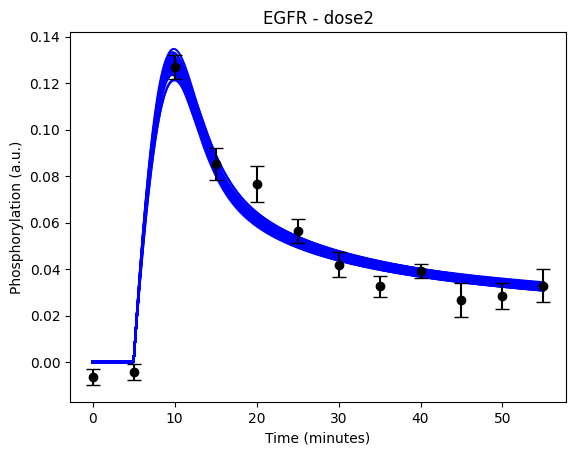

In [294]:
# Plot the uncertainty for the model
plot_uncertainty(all_params_M1, m1_sims, data)

### Testing the model by predicting the validation data

#### Create the simulation object

In [295]:
# define validation activity
activityValidationM1 = sund.Activity(timeunit='m')
activityValidationM1.AddOutput(sund.PIECEWISE_CONSTANT, "A_in", tvalues = data_validation['step_dose']['input']['A_in']['t'], fvalues=data_validation['step_dose']['input']['A_in']['f'])

m1_validation = {}
m1_validation['step_dose'] = sund.Simulation(models = m1, activities = activityValidationM1, timeunit = 'm')

#### Define a function to plot the validation experiment

In [296]:
# Define the plot_sim_with_data function
def plot_validation_with_data(all_params, sims, data_validation, data, c='b', n_params_to_plot=200):

    random.shuffle(all_params)

    for idx, experiment in enumerate(data_validation):
        plt.figure(1)
        timepoints = np.arange(0, data_validation[experiment]["time"][-1]+0.01, 0.01)
        for params in all_params[:n_params_to_plot]:
            plot_sim(params, sims[experiment], timepoints, c=c)

        plot_dataset(data_validation[experiment], 'none') # Plot the validation data
        plt.title('EGFR - Validation')
    plot_dataset(data['dose1'])    # Since the first part of the validation is the same as for the first dose, we also plot that data

#### Plot the agreement, calculate the cost, and evaluate the agreement

Cost (validation): 45.13919294038026
Chi2 limit: 15.50731305586545
Cost > limit (rejected?): True


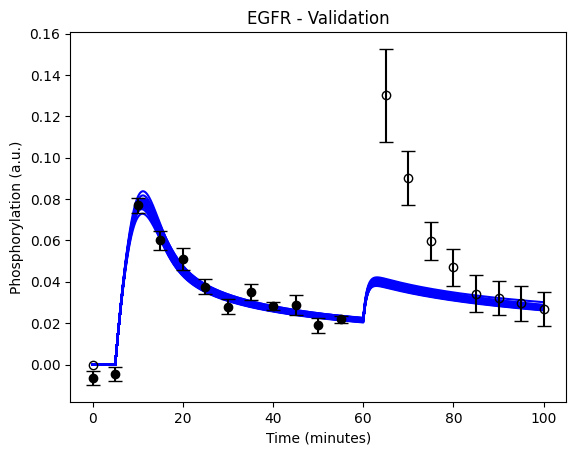

In [297]:
# Test the model against the evaluation experiment
plot_validation_with_data(all_params_M1, m1_validation, data_validation, data, c='b')

cost_m1_validation = fcost(p_opt_M1, m1_validation, data_validation)

dgf_validation=0
for experiment in data_validation:
    dgf_validation += np.count_nonzero(np.isfinite(data_validation[experiment]["SEM"]))
chi2_limit_validation = chi2.ppf(0.95, dgf_validation)

print(f"Cost (validation): {cost_m1_validation}")
print(f"Chi2 limit: {chi2_limit_validation}")
print(f"Cost > limit (rejected?): {cost_M1>chi2_limit_validation}")

### Testing an alternative hypothesis

#### Implement the alternative model M2

In [298]:
# Print the model to a file called 'M2.txt'

model_name = "M2"

with open(f"{model_name}.txt",'w') as f:
    f.write(f"""
########## NAME
{model_name}
########## METADATA
timeunit = m
########## MACROS
########## STATES
d/dt(R) = r2-r1
d/dt(Rp) = r1-r2
d/dt(S) = r4-r5
d/dt(Sp) = r5-r4
d/dt(A) = - r3

R(0) = 1.0
Rp(0) = 0.0
S(0) = 1.0
Sp(0) = 0.0
A(0) = 0.0
########## PARAMETERS
k1 = 5.0
k2 = 20.0
kfeed = 10.0
k4 = 15.0
k5 = 30.0
########## VARIABLES
r1 = R*A*k1
r2 = Rp*k2
r3 = A*Sp*kfeed
r4 = Sp*k4
r5 = S*Rp*k5
########## FUNCTIONS
########## EVENTS
event1 = A_in>0, A, A_in
event2 = A_in=0
########## OUTPUTS
########## INPUTS
A_in = A_in @ 0
########## FEATURES
y_sim = Rp
""")

#### Test if the model agrees with data, in the same way as for the first hypothesis

Model 'M2' is already installed and up to date.


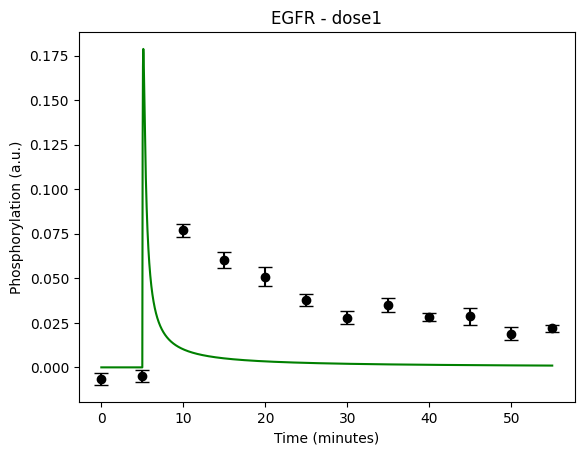

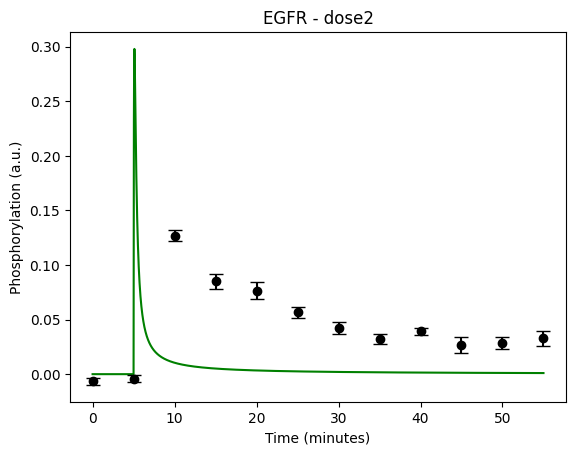

Cost of the M2 model: 2e+30
Cost > limit (rejected?): True


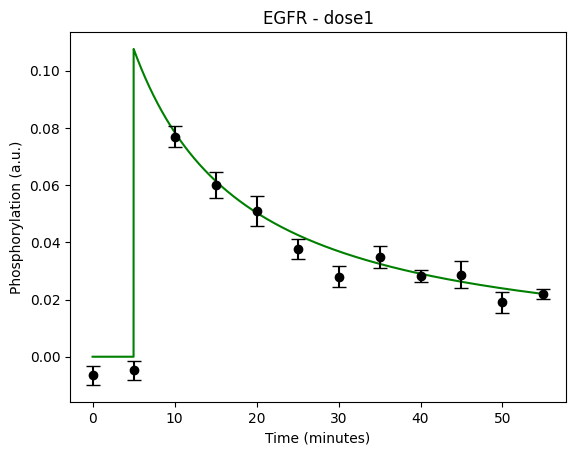

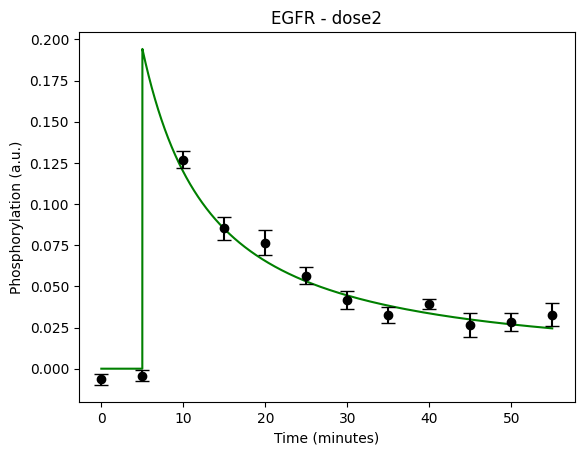

[ 6.18693481  8.30157016  5.31650467 11.51292472  5.92122354]

Optimized parameter values: [  486.35305579  4030.19549771   203.67073905 99999.92507662
   372.86765513]
Optimized cost: 33.75236369262981
chi2-limit: 36.41502850180731
Cost > limit (rejected?): False


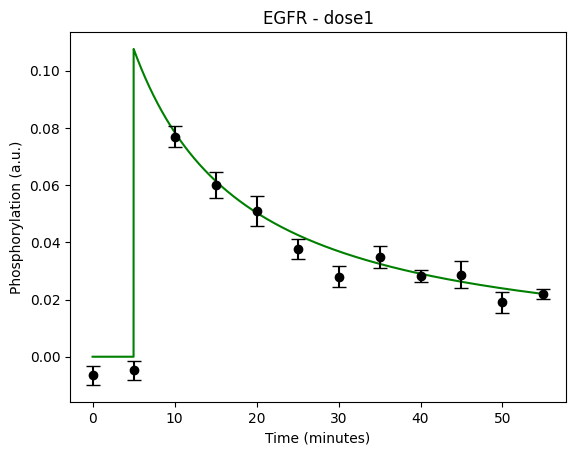

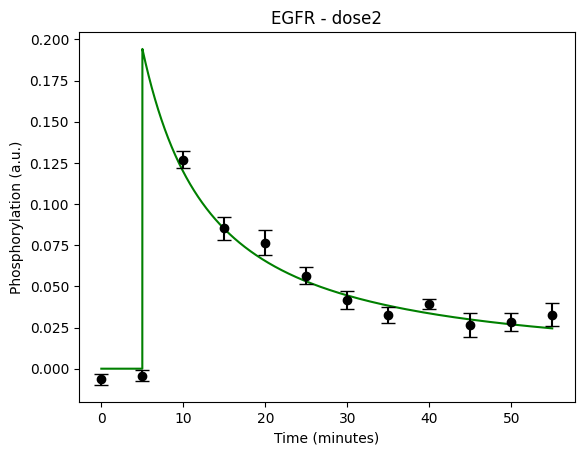

In [300]:
# Set up M2
# Install the simple model by using the sund function 'installModel'
# To see that the model has been installed try running 'installedModels' afterwards
sund.installModel("M2.txt")

# Import the simple model by using the sund function 'importModel'
# The function return the model class which should be stored in variable, say 'SimpleModel'
M2 = sund.importModel("M2")
m2 = M2()

# Create a new Simulation object for the M2 object using the constructor `sund.Simulation(models=models)` from the sund package.
m2_sims ={}
m2_sims['dose1'] = sund.Simulation(models = m2, activities = activity1, timeunit = 'm')
m2_sims['dose2'] = sund.Simulation(models = m2, activities = activity2, timeunit = 'm')

# Simulate the m2_simulation object, remember to specify the timevector ([times to simulate]) and timeunit ('s' | 'm' | 'h' ).
timepoints = np.arange(0, 60.01, 0.01) # 1000 points between 0 and 60.
m2_sims['dose1'].Simulate(timevector=timepoints)
m2_sims['dose2'].Simulate(timevector=timepoints)

# Plot the model with the given parameter values:
params0_m2 = [5, 20, 10, 15, 30]# = [k1, k2, kfeed, k4, k5]

plot_sim_with_data(params0_m2, m2_sims, data, 'g')
plt.show()

# Calculate the cost for the given parameter values:
fcost(params0_m2, m2_sims, data)
cost_m2 =  fcost(param_fail, m2_sims, data)
print(f"Cost of the M2 model: {cost_m2}")
print(f"Cost > limit (rejected?): {cost_m2>chi2_limit}")

# Find a better parameter set manually:
params_guess_M2 = [486.35305579074378,4030.1954977108358,203.67073905125929,99999.9250766247,372.86765513472358]# = [k1, k2, kfeed, k4, k5]
plot_sim_with_data(params_guess_M2, m2_sims, data, 'g')
plt.show()

# Setup for optimization
## define callback for M2
def callback_evolution_M2(x, convergence): # The callback to the differential_evolution optimizer returns both the current point x, and state of convergence
    callback(x, file_name='M2-temp-evolution')
## Set bounds and additional arguments
x0_log_M2 = np.log(params_guess_M2)
bounds_M2 =Bounds([np.log(1e-6)]*len(x0_log_M2), [np.log(1e6)]*len(x0_log_M2))
args_M2 = (m2_sims, data)

# Run the optimization
print(x0_log_M2)

resM2 = differential_evolution(fcost_log, bounds_M2, args=args_M2, x0=x0_log_M2, callback=callback_evolution_M2, disp=True)
resM2['x'] = np.exp(resM2['x'])

print(f"\nOptimized parameter values: {resM2['x']}")
print(f"Optimized cost: {resM2['fun']}")
print(f"chi2-limit: {chi2_limit}")
print(f"Cost > limit (rejected?): {resM2['fun']>chi2_limit}")

if resM2['fun'] < chi2_limit: #Saves the parameter values, if the cost was below the limit.
    file_name = f"M2 ({resM2['fun']:.3f}).json"
    with open(file_name,'w') as file:
        resM2['x'] = resM2['x'] #We save the file as a .json file
        json.dump(resM2, file, cls=NumpyArrayEncoder)

# Use the best found parameter sets to plot the agreement to data
p_opt_M2 = resM2['x']
plot_sim_with_data(p_opt_M2, m2_sims, data, 'g')

#### Run the optimization a few more times
Often it is a good idea to use the best found parameter set as the starting guess for the next iteration

In [301]:
# Rerun the optimization 4 times
x0_log_M2 = np.log(params0_m2) 
for i in range(4): 
    resM2 = differential_evolution(fcost_log, bounds_M2, args=args_M2, x0=x0_log_M2, callback=callback_evolution_M2, disp=True)
    x0_log_M2 = resM2['x']
    
resM2['x'] = np.exp(resM2['x'])
print(f"\nOptimized parameter values: {resM2['x']}")
print(f"Optimized cost: {resM2['fun']}")
print(f"chi2-limit: {chi2_limit}")
print(f"Cost > limit (rejected?): {resM2['fun']>chi2_limit}")


Optimized parameter values: [  486.35305579  4030.19549771   203.67073905 99999.92507662
   372.86765513]
Optimized cost: 33.75236369262981
chi2-limit: 36.41502850180731
Cost > limit (rejected?): False
Iter:    0, obj:33.750726
Iter:    1, obj:33.750589

Optimized parameter values: [  486.35260256  4030.19653303   203.64262972 99984.43976557
   372.86731228]
Optimized cost: 33.75058881903004
chi2-limit: 36.41502850180731
Cost > limit (rejected?): False
Iter:    0, obj:33.750584
Iter:    1, obj:33.750577
Iter:    2, obj:33.750577

Optimized parameter values: [  486.35259046  4030.19614764   203.62326101 99984.43806711
   372.86731709]
Optimized cost: 33.75057658796581
chi2-limit: 36.41502850180731
Cost > limit (rejected?): False
Iter:    0, obj:33.750577

Optimized parameter values: [  486.35259046  4030.19614766   203.62326101 99984.43806756
   372.86731709]
Optimized cost: 33.7505765858883
chi2-limit: 36.41502850180731
Cost > limit (rejected?): False


#### Collect the uncertainty for model 2

In [302]:
# Create an empty list to store multiple parameter sets
all_params_M2 = []

In [305]:
# Run the optimization a couple times and store the satisfactory parameters in the above created list.
x0_log_M2_unc = np.log(params0_m2) # = [k1, k2, kfeed, k4, k5]
for i in range(4):
    niter = 0 # Reset the iteration counter
    args_M2 = (m2_sims, data, all_params_M2)
    res_uncM2 = differential_evolution(fcost_uncertainty, bounds_M2, args=args_M2, x0=x0_log_M2_unc, callback=callback_evolution_M2, disp=True)
    x0_log_M2_unc = res_uncM2['x']

# Save the accepted parameters to a csv file
with open('all_params_M2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows(all_params_M2)

Iter:    0, obj:33.751962
Iter:    0, obj:33.751953
Iter:    1, obj:33.751944
Iter:    2, obj:33.751887
Iter:    3, obj:33.751887
Iter:    4, obj:33.751860
Iter:    5, obj:33.751860
Iter:    6, obj:33.751844
Iter:    7, obj:33.751842
Iter:    8, obj:33.751842
Iter:    9, obj:33.751842


In [306]:
# load the accepted parameters from the csv file
with open('all_params_M2.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    all_params_M2 = list(reader)

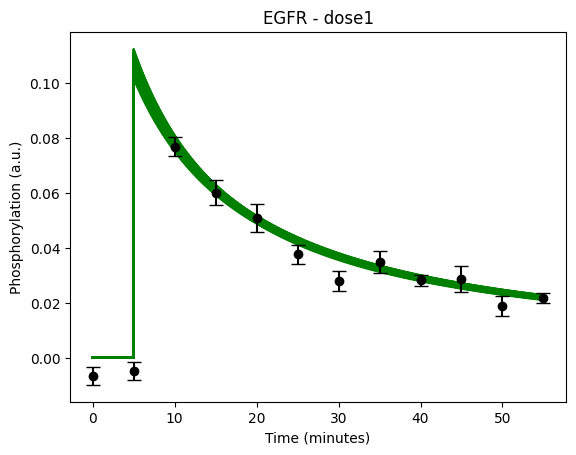

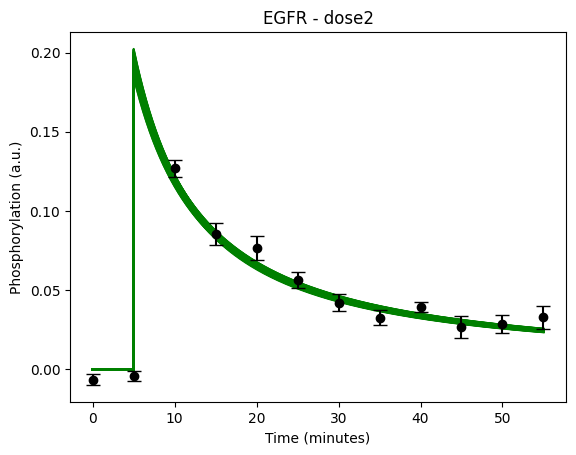

In [307]:
# Plot your accepted parameters for model M2
plot_uncertainty(all_params_M2, m2_sims, data, 'g')

#### Plot the agreement to the validation data and test the agreement with a $\chi^2$-test

Cost (validation): 3.462682634612413
Chi2 limit: 15.50731305586545
Cost > limit (rejected?): True


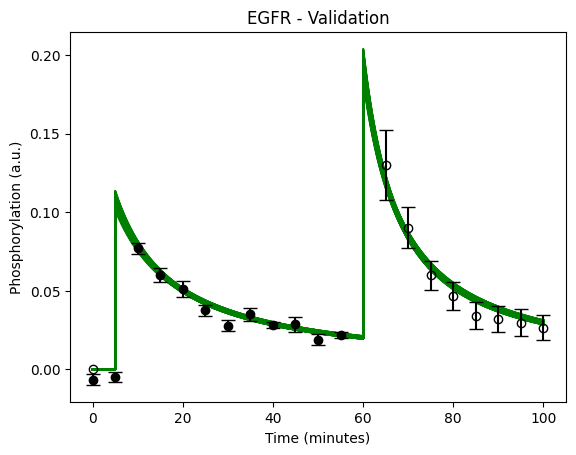

In [309]:
# Setup the simulation and plot the validation experiment
activityValidationM2 = sund.Activity(timeunit='m')
activityValidationM2.AddOutput(sund.PIECEWISE_CONSTANT, "A_in", tvalues = [5, 30, 60], fvalues=[0,1,0,2])

m2_validation = {}
m2_validation['step_dose'] = sund.Simulation(models = m2, activities = activityValidationM2, timeunit = 'm')

plot_validation_with_data(all_params_M2, m2_validation, data_validation, data, c='g')

cost_m2_validation = fcost(p_opt_M2, m2_validation, data_validation)

print(f"Cost (validation): {cost_m2_validation}")
print(f"Chi2 limit: {chi2_limit_validation}")
print(f"Cost > limit (rejected?): {cost_M1>chi2_limit_validation}")

### using the model to predict unknown scenarios

#### Define a new version of M2 which can also simulate the effect of the inhibitor


In [334]:
# Use M2 for predictions - inhibit RSp feedback on S breakdown

model_name = "M2_pred"

with open(f"{model_name}.txt",'w') as f:
    f.write(f"""
########## NAME
{model_name}
########## METADATA
timeunit = m
########## MACROS
########## STATES
d/dt(R) = r2-r1
d/dt(Rp) = r1-r2
d/dt(S) = r4-r5
d/dt(Sp) = r5-r4
d/dt(A) = - r3

R(0) = 1.0
Rp(0) = 0.0
S(0) = 1.0
Sp(0) = 0.0
A(0) = 0.0
########## PARAMETERS
k1 = 5.0
k2 = 20.0
kfeed = 10.0
k4 = 15.0
k5 = 30.0
########## VARIABLES
r1 = R*A*k1
r2 = Rp*k2
r3 = A*kfeed*Sp*(1/inhibitor)
r4 = Sp*k4
r5 = S*Rp*k5
########## FUNCTIONS
########## EVENTS
event1 = A_in>0, A, A_in
event2 = A_in=1.0
event3 = inhibitor>0
########## OUTPUTS
########## INPUTS
A_in = A_in @ 0
inhibitor = inhibitor @ 1.0
########## FEATURES
Receptor phosphorylated = Rp
Receptor inactive = R
Receptor substrate phosphorylated = Sp
Receptor substrate inactive = S
""")


In [335]:
# Set up M2_pred
# Install the simple model by using the sund function 'installModel'
# To see that the model has been installed try running 'installedModels' afterwards
sund.installModel("M2_pred.txt")

# Import the simple model by using the sund function 'importModel'
# The function return the model class which should be stored in variable, say 'SimpleModel'
M2_pred = sund.importModel("M2_pred")

m2_pred = M2_pred()

Model 'M2_pred' has already been imported into memory. 
Trying to unload the module, but you might need to restart Python before re-installing the model.


INFO:root:running build_ext
INFO:root:building 'sund.Models.M2_pred' extension
INFO:root:creating build
INFO:root:creating build/temp.linux-x86_64-cpython-310
INFO:root:creating build/temp.linux-x86_64-cpython-310/content
INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.10/dist-packages/sund/Models/include -I/usr/include/python3.10 -c /content/M2_pred.c -o build/temp.linux-x86_64-cpython-310/content/M2_pred.o
INFO:root:x86_64-linux-gnu-gcc -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 build/temp.linux-x86_64-cpython-310/content/M2_pred.o -L/usr/local/lib/python3.10/dist-packages/sund/Models/include -L/usr/lib/x86_64-linux-gnu -lExtraFormulas -o /usr/local/lib/python3.10/dist-packages/sund/Models/M2_pred.cpython-310-x86_64-linux-gnu.so
INFO:root:running clean
INFO:root:removing 'build/temp.linux-x86_64

Model 'M2_pred' succesfully installed.


In [331]:
# Define predicition  activity
activity_pred = sund.Activity(timeunit='m')
activity_pred.AddOutput(sund.PIECEWISE_CONSTANT, "A_in", tvalues = [5, 30, 60], fvalues=[0, 1, 0, 2])
activity_pred.AddOutput(sund.PIECEWISE_CONSTANT, "inhibitor", tvalues = [60], fvalues=[1.0, 100.0])

# Create a new Simulation object for the M2_pred object using the constructor `sund.Simulation(models=models)` from the sund package.
m2_pred_sim = {}
m2_pred_sim['inhibition'] = sund.Simulation(models = m2_pred, activities = activity_pred, timeunit = 'm')

In [332]:
# Define the plot_sim_with_data function
def plot_prediction(all_params, sims, timepoints, c='b', n_params_to_plot=200):
    for experiment in sims:
        for feature in sims[experiment].featurenames:
            plt.figure()
            for params in all_params[:n_params_to_plot]:
                try:
                    plot_sim(params, sims[experiment], timepoints, c=c, feature_to_plot=feature)
                except:
                    pass
            plt.title(f"{experiment} - {feature}")

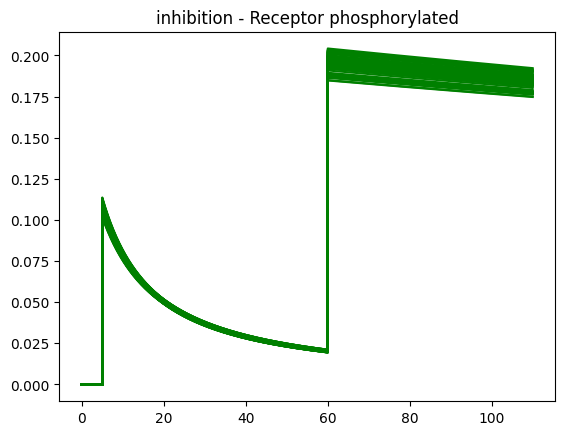

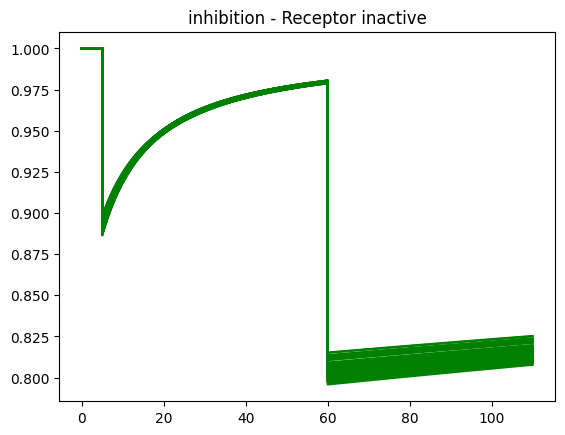

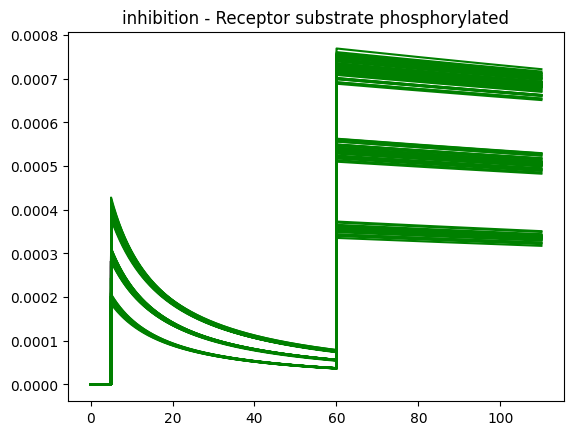

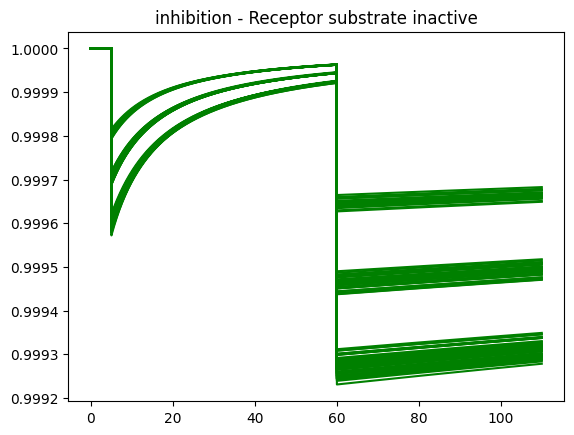

In [336]:
#Simulate and plot the predictions with M2_pred
timepoints = np.arange(0, 110.01, 0.01)
plot_prediction(all_params_M2, m2_pred_sim, timepoints, 'g')

## The end of the exercise
This marks the end of the exercise. But, we have also included some additional steps below, which might be relevant for some projects. You can do them now, or come back here later when it is relevant.

You should now know the basics of what you need to do a systems biology project

## Extra concepts not mandatory for this exercise

### Making a profile-likelihood plot (optional)

This is optional to do, but might be relevant in your future projects. Even if you do not do it now, remember that you can come back and try this out later.

<details class="admonition abstract"><summary>Read about profile-likelihood</summary>

In a profile-likelihood analysis, we plot one parameters value on the x-axis and the cost of the whole parameter set on the y-axis. Such a curve is typically referred to as a profile-likelihood curve. To get the full range of values for the parameter, it is common practice to fixate the parameter being investigated, by removing it from the list of parameters being optimized, and setting it explicitly in the cost function, and re-optimize the rest of the parameters. This is done several times, and each time the parameter is fixed to a new value, spanning a range to see how the cost is affected from changes in the value of this specific parameter (Figure 4). If the resulting curve is defined and passes a threshold for rejection in both the positive and negative direction (Figure 4A), we say that the parameter is identifiable (that is, we can define a limited interval of possible values), and if instead the cost stays low in the positive and/or the negative direction, we say that the parameter is unidentifiable (Figure 4B-D). This whole procedure is repeated for each model parameter.

![PL](http://isbgroup.eu/edu/assets/Intro/Figures/PL.png)
*Figure 4: Examples of identifiable (A) and unidentifiable parameters (B-D). The blue line is the threshold for rejection, the red line is the value of the cost function for different values of the parameter.*
In a *prediction* profile-likelihood analysis, predictions instead of parameter values are investigated over the whole range of possible values. Predictions cannot be fixated, like parameters can. Therefore, the prediction profile-likelihood analysis is often more computationally heavy to perform than the profile-likelihood analysis. Instead of fixation, a term is added to the cost to force the optimization to find a certain value of the prediction, while at the same time minimizing the residuals. Resulting in an objective function something like the following:
    
\begin{equation*}
    v\left(\theta\right) = \sum_{\forall t}\frac{{(y_t-\ {\hat{y}}_t\left(\theta\right))}^2}{{SEM}_t^2} + \lambda (p - \hat{p})
\end{equation*}
    

Again, the whole range of values of the predictions are iterated through. A prediction profile-likelihood analysis can be used in the search for core predictions.

</details>
<details class="admonition abstract"><summary>Do a profile-likelihood analysis of the parameters</summary>

Here, we will not fixate one parameter at time and reoptimize, instead we will use the already collected data. This is worse than fixing the parameters, but we will do it for the sake of time. Furthermore, as opposed to the uncertainty plots before, we do not have to select some parameter sets, we can instead use all of our collected sets. The easiest way to do a profile-likelihood plot, is to simply plot the cost against the values of one parameter. Then repeat for all parameters.
To make it slightly more pretty, one can filter the parameters to only give the lowest cost for each parameter value. This can be done by first sorting the parameters according to the overall cost, using the function `numpy.argsort`, and then using the function `numpy.unique`. A good idea is likely to round your parameter values to something with less decimals. This can be done with `numpy.round`. Note that `numpy.round` takes an optional argument: `decimals` which specify the number of decimal to store, can be a negative number.

</details>